In [2]:
!pip install awswrangler

  Using cached awswrangler-2.20.1-py3-none-any.whl (272 kB)
  Using cached pg8000-1.29.4-py3-none-any.whl (51 kB)
  Using cached backoff-2.2.1-py3-none-any.whl (15 kB)
  Using cached pyarrow-10.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.0 MB)
  Using cached PyMySQL-1.0.3-py3-none-any.whl (43 kB)
  Using cached requests_aws4auth-1.2.2-py2.py3-none-any.whl (24 kB)
  Using cached jsonpath_ng-1.5.3-py3-none-any.whl (29 kB)
  Using cached redshift_connector-2.0.910-py3-none-any.whl (112 kB)
  Using cached gremlinpython-3.6.2-py2.py3-none-any.whl (74 kB)
  Using cached progressbar2-4.2.0-py2.py3-none-any.whl (27 kB)
  Using cached opensearch_py-2.2.0-py2.py3-none-any.whl (291 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)
  Using cached aenum-3.1.12-py3-none-any.whl (131 kB)
  Using cached aiohttp-3.8.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Using cached scramp-1.4.4-py3-none-any.whl (1

In [3]:
import awswrangler as wr
import boto3
import pandas as pd
import numpy as np
import re
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

role = get_execution_role()
s3 = boto3.resource('s3')

In [33]:
def plot_time_distr(first_occurrence, title, n_days=2, delta_hours=6):
    omega_hours = 24 // delta_hours
    f, ax = plt.subplots()
    b = np.linspace(0,n_days*24*60,100)
    _ = first_occurrence.hist(bins=b, ax=ax)
    _ = ax.set_title(title)
    _ = ax.set_xticks([i*60*delta_hours for i in range(n_days*omega_hours)])
    _ = ax.set_xticklabels([i*delta_hours for i in range(n_days*omega_hours)])
    _ = ax.set_xlabel('Time [hours]')
    return f, ax

def get_data(variable_idx, variable_name, min_value, max_value, var_grp=False):
    if var_grp:
        grp_index = ['a_patientid','a_variableid']
    else:
        grp_index = 'a_patientid'
    data = []
    first_occurrence = []
    for i in tqdm(range(1,7)):
        labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
        ith = labresults_numeric[labresults_numeric.a_variableid.isin(variable_idx)]
        first_occurrence.append(ith[ith.time>=0].groupby('a_patientid').time.min())
        ith = ith[(ith.time>=0) & (ith.time<=time_window)]
        ith = ith[(ith.value >= min_value) & (ith.value <= max_value)]
        ith = ith.groupby(grp_index).agg({'value':[np.min, np.max]})
        data.append(ith)

    data = pd.concat(data)
    data.columns = [f'{variable_name}_min',f'{variable_name}_max']
    data.to_csv('./tmp/tmp_table.csv')
    data = pd.read_csv('./tmp/tmp_table.csv', index_col=0)
    data = data.reset_index()
    return data, first_occurrence

In [5]:
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('icusics-db')

tables = []
for my_bucket_object in my_bucket.objects.all():
    tables.append(my_bucket_object.key)
tables = pd.Series(tables)

In [6]:
variables = wr.s3.read_parquet(path="s3://icusics-db/d_variables/d_variables.parquet")
# variables_h4 = variables[variables.hospital_coded==4]
# diagnoses = wr.s3.read_parquet(path="s3://icusics-db/diagnoses/diagnoses_h4.parquet")
# labresults_numeric = wr.s3.read_parquet(path="s3://icusics-db/labresults_numeric/labresults_numeric_h4.parquet")

In [7]:
time_window = 24 * 60

# Check for predictors variable_id

Predictors:
 - Albumine
 - Potassium
 - Creatinine
 - Haematocrit
 - Ph
 - Blood Urine Nitrate / Urea * 0.357
 - SpO2
 - Bicarbonate [1020004200,2020004200,3020004200,51020004200,6020004200,4024001495,4024002678]

Outcome:
 - CRRT
 
Other vitals:
 - Heart Rate [1000000200, 2000000200, 3000000200, 4000000200, 5000000200, 6000000200]
 - Systolic Blood Pressure [1000000100,2000000100,3000000100,4000000100,5000000100,6000000100]
 - Diastolic Blood Pressure [1000000120,2000000120,3000000120,4000000120,5000000120,6000000120]
 - Respiratory Rate

In [8]:
cols = ['hospital_coded','table','a_variableid','name','abbreviation','description']
variables[variables.a_variableid.astype(str).str.endswith('3969')].loc[:,cols]

,hospital_coded,table,a_variableid,name,abbreviation,description
25557,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...
25558,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...
25559,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...
25560,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...
25561,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...
25562,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...
25563,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...
25564,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...
25565,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...
25566,5,observed_categoric,5015003969,Motiu d'ingrés,Motiu Ingrés,Llistat que inclou un nombre limitat de possib...


In [92]:
cols = ['hospital_coded','table','a_variableid','name','abbreviation','description']
variables[variables.a_variableid.astype(str).str.endswith('000717')].loc[:,cols]

,hospital_coded,table,a_variableid,name,abbreviation,description
5438,2,labresults_numeric,2024000717,CO3H estandar art,CO3Hs art,<NA>
10154,3,labresults_numeric,3024000717,Srm-Creatina-cinasa,CPK,<NA>
22110,5,labresults_numeric,5024000717,Srm-Creatina-cinasa,CPK,<NA>


In [97]:
key_chars = 'FR|respiracions|resp rate'
bicarb = variables[(variables["table"] == "labresults_numeric" ) &
                     ((variables['name'].str.contains(key_chars, case=False, na=False)) | (
                         variables['description'].str.contains(key_chars, case=False, na=False)) | (
                         variables['choicestringvalue'].str.contains(key_chars, case=False, na=False)) | (
                         variables['abbreviation'].str.contains(key_chars, case=False, na=False)))]

bicarb = bicarb[["hospital_coded", "a_variableid", "name","abbreviation"]]

bicarb

,hospital_coded,a_variableid,name,abbreviation
5368,2,2024000220,fracción CK-MB sérica,CK-MB
10285,3,3024001079,San-Hemoglobina A2; fr.subst,Hgb A2FrSubs
10286,3,3024001080,San-Hemoglobina F; fr.subst.,Hgb FfFrSubs
10352,3,3024001865,"cSan-Oxigen, fr.sat.",cSan-SaO2
22250,5,5024001857,"aSan-Oxigen, fr.sat.",aSan-SaO2
22257,5,5024001978,"vSan-Oxigen, fr.sat.",vSan-SvO2
26303,6,6024002859,Factors Reumatoidals,FR
26392,6,6024004005,Fracció Metahemoglobina arteri,FracMetaHB_A


In [59]:
cols = ['hospital_coded','table','a_variableid','name','abbreviation','description']
variables[variables.a_variableid.astype(str).str.endswith('000000300')].loc[:,cols]

,hospital_coded,table,a_variableid,name,abbreviation,description
577,1,monitored_numeric,1000000300,respiracions mesurades,FR,FR Pautada
5625,2,monitored_numeric,2000000300,Respiracions totals mesurades,FR,<NA>
10673,3,monitored_numeric,3000000300,FR (m),FR (m),Freqüència Respiratòria Monitor 1.REGISTRE MAN...
16191,4,monitored_numeric,4000000300,FR (m),FR (m),Respiracions totals mesurades (MONITORITZADES)
22368,5,monitored_numeric,5000000300,FR(m),FR (m),Freqüència respiratoria monitoritzada.Decarreg...
26664,6,monitored_numeric,6000000300,FR (m),FR (m),Freqüència Respiratòria Monitor 1.REGISTRE MAN...


In [11]:
variables[variables.a_variableid.astype(str).str.endswith('000000310')].loc[:,cols]

,hospital_coded,table,a_variableid,name,abbreviation,description
578,1,monitored_numeric,1000000310,FR espontània,FRspont,FR espnotàna del Draeger Evita V500
5626,2,monitored_numeric,2000000310,Frec resp espontània mesurada,FRespont,<NA>
10674,3,monitored_numeric,3000000310,FR espontània,FR espont,DI 21.CONTROL RESPIRATORI
16192,4,monitored_numeric,4000000310,FR espontanea mesurada,FR esp,Freqüència respiratòria espontanea mesurada
22369,5,monitored_numeric,5000000310,Spontaneous resp rate,FR espont,DI 21.CONTROL RESPIRATORI
26665,6,monitored_numeric,6000000310,FR espontània,FR espont,DI 21.CONTROL RESPIRATORI 2. REGISTRE MANUAL V...


In [12]:
variables[variables.a_variableid.astype(str).str.endswith('000000320')].loc[:,cols]

,hospital_coded,table,a_variableid,name,abbreviation,description
579,1,monitored_numeric,1000000320,Freqüència Respiratòria Set,FR real,FR Total real
5627,2,monitored_numeric,2000000320,Set resp rate on ventilator,FRv(s),<NA>
10675,3,monitored_numeric,3000000320,FR (p),FR (p),1.REGISTRE MANUAL contingència / M 04.VENTILAC...
16193,4,monitored_numeric,4000000320,FR programada al ventilador,FRv(p),Freqüència respiratòria programada al ventilador
22370,5,monitored_numeric,5000000320,FR pautada,FR (p),Freqüència respiratòria pautada. Decarregada d...
26666,6,monitored_numeric,6000000320,FR (p),FR (p),M 04.VENTILACIÓ MECÀNICA / DI 2. REGISTRE MAN...


In [118]:
variables[variables.a_variableid.astype(str).str.endswith('000000330')].loc[:,cols]

,hospital_coded,table,a_variableid,name,abbreviation,description
581,1,monitored_numeric,1000000330,Ventilator resp rate,RRvent,<NA>
5628,2,monitored_numeric,2000000330,Frec. resp. ventilador mesurad,FRv (m),<NA>
22371,5,monitored_numeric,5000000330,Ventilator resp rate,FRvent (p),<NA>


In [98]:
variables[variables.a_variableid.astype(str).str.endswith('000005600')].loc[:,cols]

,hospital_coded,table,a_variableid,name,abbreviation,description
656,1,monitored_numeric,1000005600,FR monitor,FR monitor,Monitored variable 1. Usada en Philips Infocen...
10747,3,monitored_numeric,3000005600,FR monitor,FR monitor,<NA>
16262,4,monitored_numeric,4000005600,FR monitor,FR monitor,Monitored variable 1. Utilitzada en Philips In...
22426,5,monitored_numeric,5000005600,FR monitor,FR monitor,Decarregada del monitor automàticament o anot...
26718,6,monitored_numeric,6000005600,FR monitor,FR monitor,1. REGISTRE MANUAL CONSTANTS VITALS


In [94]:
variables[variables.a_variableid.astype(str).str.endswith('000000340')].loc[:,cols]

,hospital_coded,table,a_variableid,name,abbreviation,description
5629,2,monitored_numeric,2000000340,Frec respiratoria espontanea,FR esp,<NA>


In [9]:
# Albumine

alb_idx = [
    1024000512,2024000340,3024001802,
    4024002341,5024001802,6024002862
]

albumine = []
tot = []
for i in tqdm(range(1,7)):
    labresults_numeric = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h{i}.parquet')
    ith = labresults_numeric[labresults_numeric.a_variableid.isin(alb_idx)]
    tot.append(ith)
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    if i == 1:
        ith.loc[:,'value'] = ith.loc[:,'value'] / 10
    ith = ith[(ith.value >= 0.5) & (ith.value <= 15)]
    ith = ith.groupby('a_patientid').agg({'value':[np.min, np.max]})
    albumine.append(ith)
    
albumine = pd.concat(albumine)
albumine.columns = ['albumine_min','albumine_max']
albumine.to_csv('./tmp/tmp_table.csv')
albumine = pd.read_csv('./tmp/tmp_table.csv', index_col=0)
albumine.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,albumine_min,albumine_max
a_patientid,,
1000091,2.43,2.43
1000109,2.68,2.68
1002069,1.86,2.16
1002635,3.32,3.32
1002875,2.15,2.15


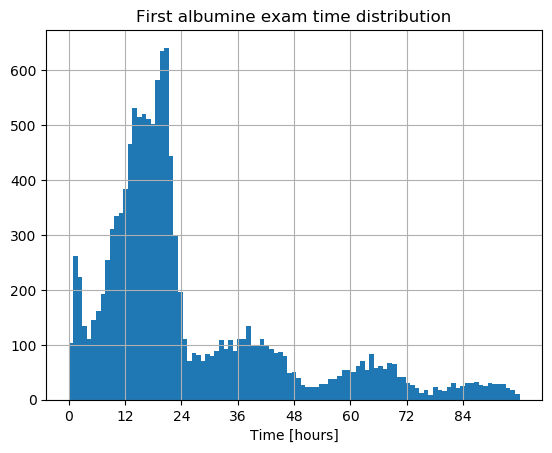

In [10]:
tot = pd.concat(tot)
tot = tot.groupby('a_patientid').time.min()
f, ax = plot_time_distr(tot, 'First albumine exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [14]:
# Potassium

potassium_idx = [
    1020000500,2020000500,3020000500,
    4020000500,5020000500,6020000500
]

potassium, K_first_time = get_data(
    potassium_idx,
    'potassium',
    min_value=2, max_value=10
)
potassium.head(10)

,a_patientid,potassium_min,potassium_max
0,1000091,2.99,2.99
1,1000109,2.50,3.20
2,1000211,4.47,4.47
3,1001170,3.40,4.10
4,1001535,3.60,3.80
5,1001899,3.20,3.50
6,1002069,3.53,3.94
7,1002635,4.77,4.77
8,1002875,4.33,4.33
9,1003133,4.13,4.13


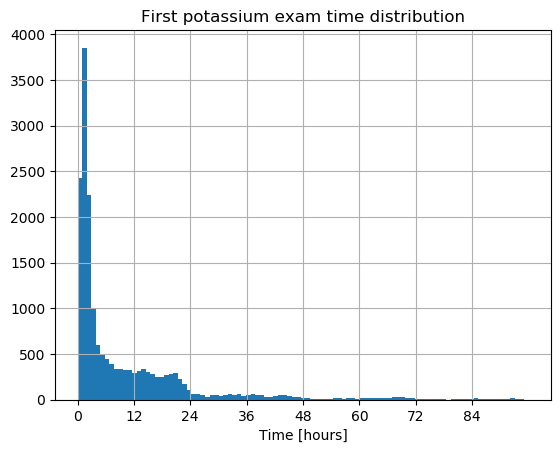

In [15]:
K_first_time = pd.concat(K_first_time)
f, ax = plot_time_distr(K_first_time, 'First potassium exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [16]:
# Creatinine

scr_idx = [   
    1020000600,2020000600,3020000600,
    4020000600,5020000600,6020000600
]

scr, scr_first_time = get_data(
    scr_idx,
    'scr',
    min_value=-100, max_value=1000
)
scr.head(10)

,a_patientid,scr_min,scr_max
0,1000091,0.86,0.86
1,1000109,1.07,1.07
2,1000211,0.33,0.33
3,1002069,1.06,1.36
4,1002635,1.23,1.23
5,1002875,0.60,0.60
6,1003133,0.48,0.48
7,1003151,1.01,1.01
8,1003452,4.15,4.15
9,1003886,1.16,1.16


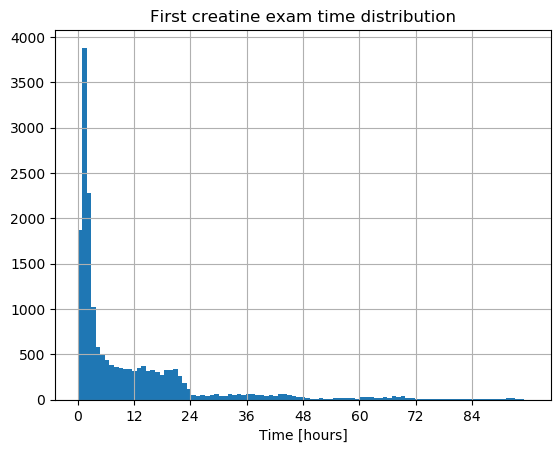

In [17]:
scr_first_time = pd.concat(scr_first_time)
f, ax = plot_time_distr(scr_first_time, 'First creatine exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [18]:
# Haematocrit

haema_idx = [
    1020000100,2020000100,3020000100,
    4020000100,5020000100,6020000100
]

haematocrit, hae_first_time = get_data(
    haema_idx,
    'haematocrit',
    min_value=5, max_value=80
)
haematocrit.head(10)

,a_patientid,haematocrit_min,haematocrit_max
0,1000091,28.5,28.5
1,1000109,29.0,33.0
2,1000211,36.8,36.8
3,1000999,34.6,35.5
4,1001170,19.0,27.0
5,1001535,46.0,47.0
6,1001899,37.0,43.0
7,1002069,32.5,39.6
8,1002286,27.5,27.5
9,1002304,31.9,31.9


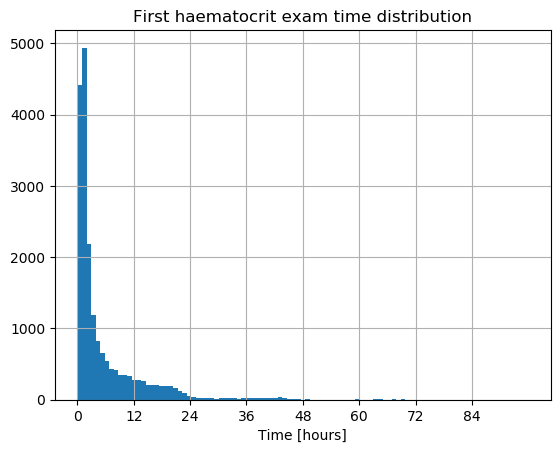

In [19]:
hae_first_time = pd.concat(hae_first_time)
f, ax = plot_time_distr(hae_first_time, 'First haematocrit exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [20]:
# Ph

ph_idx = [
    1020000300,2020000300,3020000300,
    4024001491,5020000300,6020000300
]

ph, ph_first_time = get_data(
    ph_idx,
    'ph',
    min_value=6.5, max_value=7.8
)
ph.head(10)

,a_patientid,ph_min,ph_max
0,1000109,7.46,7.49
1,1000999,7.40,7.50
2,1001000,7.29,7.42
3,1001170,7.28,7.41
4,1001535,7.34,7.46
5,1001899,7.34,7.42
6,1002286,7.36,7.36
7,1003295,7.47,7.47
8,1003452,7.35,7.51
9,1003886,7.46,7.46


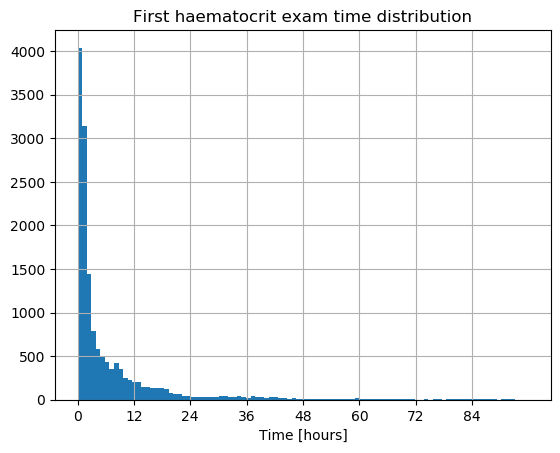

In [21]:
ph_first_time = pd.concat(ph_first_time)
f, ax = plot_time_distr(ph_first_time, 'First haematocrit exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [22]:
# Blood Urine Nitrogen
# urea * 0.357

bun_idx = [
    1020004100,2020004100,3020004100,
    4020004100,5024001806,5020004100,
    6020004100
]

bun, bun_first_time = get_data(
    bun_idx,
    'bun',
    min_value=-100, max_value=1000
)
bun.bun_min *= 0.357
bun.bun_max *= 0.357
bun.head(10)

,a_patientid,bun_min,bun_max
0,1000091,15.708,15.708
1,1000109,21.777,21.777
2,1000211,14.280,14.280
3,1002069,29.631,43.197
4,1002635,12.495,12.495
5,1002875,14.994,14.994
6,1003133,3.570,3.570
7,1003151,13.923,13.923
8,1003452,44.625,44.625
9,1003886,23.205,23.205


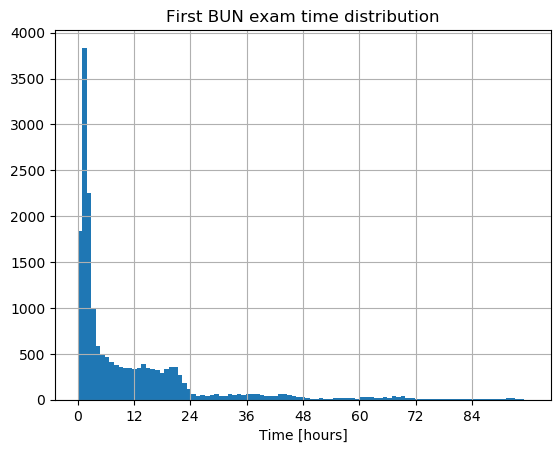

In [23]:
bun_first_time = pd.concat(bun_first_time)
f, ax = plot_time_distr(bun_first_time, 'First BUN exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [9]:
# Bicarbonate

## Hospital 4 values

labresults = wr.s3.read_parquet(f's3://icusics-db/labresults_numeric/labresults_numeric_h4.parquet')
bic_4 = labresults[labresults.a_variableid.isin([4024001495,4024002678])]

bic4_24h = bic_4[(bic_4.time>0) & (bic_4.time<=24)]
bic4_24h_p = pd.pivot_table(
    bic4_24h,
    index=['a_patientid','time'],
    columns='a_variableid',
    values='value',
    aggfunc='mean'
).reset_index().sort_values(by=['a_patientid','time'])

bic4_24h_p.head(10)

a_variableid,a_patientid,time,4024001495,4024002678
0,4004551,6,25.5,23.6
1,4007154,16,26.0,25.3
2,4007154,19,28.2,25.8
3,4009958,24,30.1,26.8
4,4010377,8,28.4,25.4
5,4010377,20,30.9,25.4
6,4010684,16,21.9,22.7
7,4010740,18,24.3,23.9
8,4010740,24,22.6,22.5
9,4011242,23,32.0,30.1


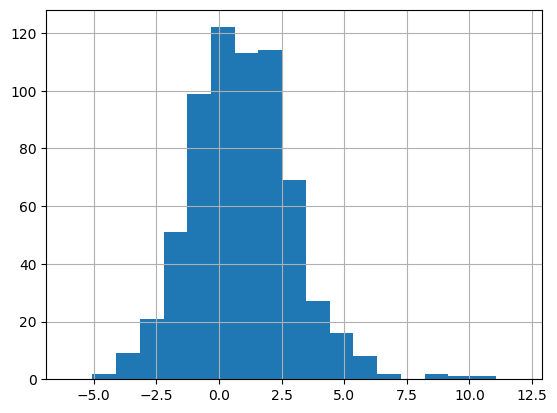

In [16]:
b = np.linspace(-6,12,20)
_ = (bic4_24h_p.iloc[:,-2] - bic4_24h_p.iloc[:,-1]).hist(bins=b)
plt.show()

In [27]:
bicarbonate_idx = [
    1024000605, 
    2024000290, # 2024000434 venus 
    3024002041,3024005910, # 3024001976,
    4024002678,
    5024002041,
    6020004200
]

variables[variables.a_variableid.isin(bicarbonate_idx)]

,hospital_coded,table,a_variableid,choicecode,choicestringvalue,name,abbreviation,description
301,1,labresults_numeric,1024000605,NaN,<NA>,Derived value of standard HCO3,HCO3std,The parameter standard bicarbonate concentrati...
5370,2,labresults_numeric,2024000290,NaN,<NA>,bicarbonato stnd arterial,sHCO3 art,<NA>
10377,3,labresults_numeric,3024002041,NaN,<NA>,aSan-Bicarbonat ecf,aSan-HCO3-ec,Arterial blood bicarbonate
10407,3,labresults_numeric,3024005910,NaN,<NA>,Bicarbonat estandar arterial,HCO3- st art,<NA>
16060,4,labresults_numeric,4024002678,NaN,<NA>,HCO3- Standard,HCO3-std,<NA>
22265,5,labresults_numeric,5024002041,NaN,<NA>,aSan-Bicarbonat ecf,aSan-HCO3-ec,Arterial blood bicarbonate
26295,6,labresults_numeric,6020004200,NaN,<NA>,Bicarbonat standard,HCO3 art,<NA>


In [44]:
# Bicarbonate

bicarbonate_idx = [
    1024000605, 
    2024000290, # 2024000434 venus 
    3024001976,3024002041,3024005910,
    4024002678,
    5024002041,
    6020004200
]

# bic_2, bic_ft_2 = get_data(
#     bicarbonate_idx,
#     'bicarbonate',
#     min_value=-100, max_value=1000,
#     var_grp=False
# )
# bic_2.head(10)

In [45]:
# Bicarbonate

bicarbonate_idx = [
    1020004200,2020004200,3020004200,
    51020004200,6020004200,4024001495,4024002678,
    1024000605, 
    2024000290, # 2024000434 venus 
    3024001976,3024002041,3024005910,
    4024002678,
    5024002041,
    6020004200
]

bicarbonate, bic_first_time = get_data(
    bicarbonate_idx,
    'bicarbonate',
    min_value=-100, max_value=1000
)
bicarbonate.head(10)

,a_patientid,bicarbonate_min,bicarbonate_max
0,1000109,25.1,27.2
1,1001000,19.8,24.6
2,1001170,20.3,23.0
3,1001535,23.9,27.4
4,1001899,22.4,25.1
5,1003295,21.8,23.5
6,1003452,17.5,25.3
7,1004363,4.9,29.7
8,1005172,18.8,22.2
9,1006008,28.7,34.9


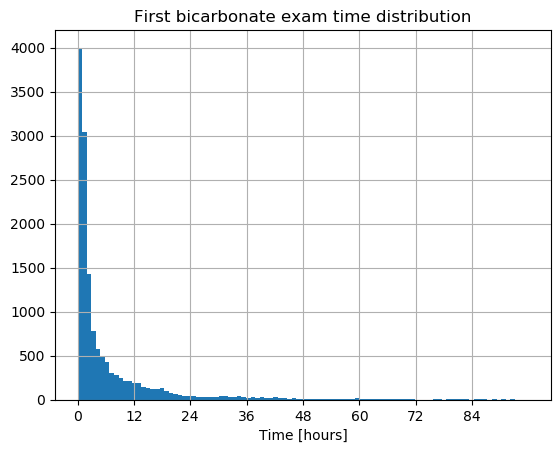

In [46]:
bic_first_time = pd.concat(bic_first_time)
f, ax = plot_time_distr(bic_first_time, 'First bicarbonate exam time distribution',
    n_days=4, delta_hours=12
)
plt.show()

In [47]:
from functools import partial

q05 = partial(np.quantile, q=0.05)
q95 = partial(np.quantile, q=0.95)

def process_ith(df_ith, time_window, var_idx, value_min=None, value_max=None):
    ith = df_ith[df_ith.a_variableid.isin(var_idx)]
    ith = ith[(ith.time>=0) & (ith.time<=time_window)]
    if value_min is not None:
        ith = ith[ith.value >= value_min]
    if value_max is not None:
        ith = ith[ith.value <= value_max]
    ith = ith.groupby('a_patientid').agg({'value':[q05, q95]})
    ith.columns = ['min','max']
    return ith

def finalize_df(list_df, var_name):
    df = pd.concat(list_df)
    df.columns = [f'{var_name}_min',f'{var_name}_max']
    df.to_csv('./tmp/tmp_table.csv')
    df = pd.read_csv('./tmp/tmp_table.csv')
    return df

In [48]:
codes = {
    'spo2': {'codes': [1000004000,2000004000,3000004000,4000004000,5000004000,6000004000],
             'vmin': 0, 'vmax': 100},
    'hr': {'codes': [1000000200,2000000200,3000000200,4000000200,5000000200,6000000200],
          'vmin': 20, 'vmax': 220},
    'sbp': {'codes': [1000000600,2000000600,3000000600,4000000600,5000000600,6000000600],
           'vmin': 60, 'vmax': 200},
    'sbp1': {'codes': [1000000100,2000000100,3000000100,4000000100,5000000100,6000000100],
           'vmin': 60, 'vmax': 200},
    'mbp': {'codes': [1000000610,2000000610,3000000610,4000000610,5000000610,6000000610],
           'vmin': 40, 'vmax': 180},
    'mbp1': {'codes': [1000000110,2000000110,3000000110,4000000110,5000000110,6000000110],
           'vmin': 40, 'vmax': 180},
    'dbp': {'codes': [1000000620,2000000620,3000000620,4000000620,5000000620,6000000620],
           'vmin': 30, 'vmax': 130},
    'dbp1': {'codes': [1000000120,2000000120,3000000120,4000000120,5000000120,6000000120],
           'vmin': 30, 'vmax': 130},
    'fr': {'codes': [1000000300,2000000300,3000000300,4000000300,5000000300,6000000300],
          'vmin': 5, 'vmax': 60},
    'fr1': {'codes': [1000000310,2000000310,3000000310,4000000310,5000000310,6000000310],
          'vmin': 5, 'vmax': 60},
    'fr2': {'codes': [1000000320,2000000320,3000000320,4000000320,5000000320,6000000320],
          'vmin': 5, 'vmax': 60},
    'fr3': {'codes': [1000000330,2000000330,3000000330,4000000330,5000000330,6000000330],
          'vmin': 5, 'vmax': 60},
    'fr4': {'codes': [1000005600,2000005600,3000005600,4000005600,5000005600,6000005600],
          'vmin': 5, 'vmax': 60},
}

vitals_list = {k: [] for k in codes.keys()}
for tbl_name in tqdm(tables.str.extract('(.*monitored_numeric.*)').dropna()[0].values):
    ith_monitored = wr.s3.read_parquet(f's3://icusics-db/{tbl_name}')
    for k,v in codes.items():
        processed_ith = process_ith(ith_monitored, time_window, v['codes'], v['vmin'], v['vmax'])
        vitals_list[k].append(processed_ith)

vitals_df = dict.fromkeys(list(codes.keys()), None)
for k,v in vitals_list.items():
    vitals_df[k] = finalize_df(v, k)

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


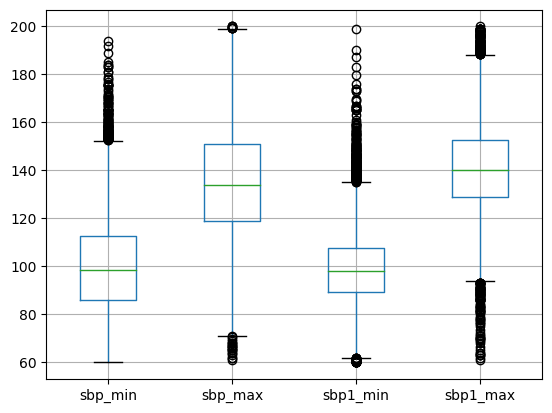

In [49]:
sbp = vitals_df['sbp'].merge(vitals_df['sbp1'], how='outer', on='a_patientid')
sbp.drop(columns=['a_patientid']).boxplot()
plt.show()

In [50]:
sbp['sbp_min_new'] = np.where(sbp.sbp_min.isna(), sbp.sbp1_min, sbp.sbp_min)
sbp['sbp_max_new'] = np.where(sbp.sbp_max.isna(), sbp.sbp1_max, sbp.sbp_max)
sbp.isna().sum() / sbp.shape[0]

a_patientid    0.000000
sbp_min        0.180716
sbp_max        0.180716
sbp1_min       0.458784
sbp1_max       0.458784
sbp_min_new    0.000000
sbp_max_new    0.000000
dtype: float64

In [51]:
mbp = vitals_df['mbp'].merge(vitals_df['mbp1'], how='outer', on='a_patientid')
mbp['mbp_min_new'] = np.where(mbp.mbp_min.isna(), mbp.mbp1_min, mbp.mbp_min)
mbp['mbp_max_new'] = np.where(mbp.mbp_max.isna(), mbp.mbp1_max, mbp.mbp_max)
mbp.isna().sum() / mbp.shape[0]

a_patientid    0.000000
mbp_min        0.183583
mbp_max        0.183583
mbp1_min       0.456709
mbp1_max       0.456709
mbp_min_new    0.000000
mbp_max_new    0.000000
dtype: float64

In [52]:
dbp = vitals_df['dbp'].merge(vitals_df['dbp1'], how='outer', on='a_patientid')
dbp['dbp_min_new'] = np.where(dbp.dbp_min.isna(), dbp.dbp1_min, dbp.dbp_min)
dbp['dbp_max_new'] = np.where(dbp.dbp_max.isna(), dbp.dbp1_max, dbp.dbp_max)
dbp.isna().sum() / dbp.shape[0]

a_patientid    0.000000
dbp_min        0.182356
dbp_max        0.182356
dbp1_min       0.456875
dbp1_max       0.456875
dbp_min_new    0.000000
dbp_max_new    0.000000
dtype: float64

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


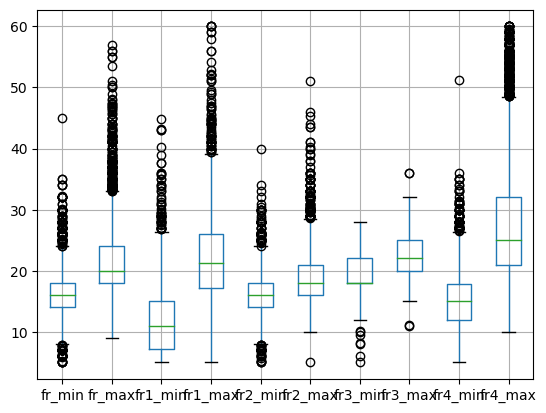

In [53]:
fr = vitals_df['fr'].merge(vitals_df['fr1'], how='outer', on='a_patientid')
fr = fr.merge(vitals_df['fr2'], how='outer', on='a_patientid')
fr = fr.merge(vitals_df['fr3'], how='outer', on='a_patientid')
fr = fr.merge(vitals_df['fr4'], how='outer', on='a_patientid')
ax = fr.drop(columns=['a_patientid']).boxplot()
plt.show()

In [54]:
fr.isna().sum() / fr.shape[0]

a_patientid    0.000000
fr_min         0.477206
fr_max         0.477206
fr1_min        0.816349
fr1_max        0.816349
fr2_min        0.527541
fr2_max        0.527541
fr3_min        0.977824
fr3_max        0.977824
fr4_min        0.263901
fr4_max        0.263901
dtype: float64

In [55]:
fr

,a_patientid,fr_min,fr_max,fr1_min,fr1_max,fr2_min,fr2_max,fr3_min,fr3_max,fr4_min,fr4_max
0,1000109,16.0,21.0,NaN,NaN,16.0,18.0,NaN,NaN,16.00,19.00
1,1000211,14.0,14.0,NaN,NaN,14.0,14.0,NaN,NaN,14.00,23.30
2,1000999,15.0,18.0,NaN,NaN,16.0,23.0,NaN,NaN,16.00,23.00
3,1001000,21.0,22.0,NaN,NaN,21.0,21.0,NaN,NaN,18.35,23.00
4,1001170,20.0,20.0,NaN,NaN,20.0,20.0,NaN,NaN,15.65,41.35
...,...,...,...,...,...,...,...,...,...,...,...
15372,6998109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.00,22.00
15373,6998382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.00,25.00
15374,6998565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.00,21.00
15375,6998846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.00,22.00


In [61]:
fr['fr_min_new'] = np.where(fr.fr_min.isna(), fr.fr4_min, fr.fr_min)
fr['fr_max_new'] = np.where(fr.fr_max.isna(), fr.fr4_max, fr.fr_max)

fr['fr_min_new'] = np.where(fr.fr_min_new.isna(), fr.fr_min, fr.fr_min_new)
fr['fr_max_new'] = np.where(fr.fr_max_new.isna(), fr.fr_max, fr.fr_max_new)

fr['fr_min_new'] = np.where(fr.fr_min_new.isna(), fr.fr2_min, fr.fr_min_new)
fr['fr_max_new'] = np.where(fr.fr_max_new.isna(), fr.fr2_max, fr.fr_max_new)

fr['fr_min_new'] = np.where(fr.fr_min_new.isna(), fr.fr1_min, fr.fr_min_new)
fr['fr_max_new'] = np.where(fr.fr_max_new.isna(), fr.fr1_max, fr.fr_max_new)

fr['fr_min_new'] = np.where(fr.fr_min_new.isna(), fr.fr3_min, fr.fr_min_new)
fr['fr_max_new'] = np.where(fr.fr_max_new.isna(), fr.fr3_max, fr.fr_max_new)

fr.isna().sum() / fr.shape[0]

a_patientid    0.000000
fr_min         0.477206
fr_max         0.477206
fr1_min        0.816349
fr1_max        0.816349
fr2_min        0.527541
fr2_max        0.527541
fr3_min        0.977824
fr3_max        0.977824
fr4_min        0.263901
fr4_max        0.263901
fr_min_new     0.000000
fr_max_new     0.000000
dtype: float64

In [62]:
vitals = vitals_df['spo2'].merge(vitals_df['hr'], how='outer', on='a_patientid')
# vitals = vitals.merge(vitals_df['sbp'], how='outer', on='a_patientid')
# vitals = vitals.merge(vitals_df['mbp'], how='outer', on='a_patientid')
# vitals = vitals.merge(vitals_df['dbp'], how='outer', on='a_patientid')
# vitals = vitals.merge(vitals_df['fr'], how='outer', on='a_patientid')
vitals = vitals.merge(sbp.loc[:, ['a_patientid','sbp_min_new','sbp_max_new']], how='outer', on='a_patientid')
vitals = vitals.merge(mbp.loc[:, ['a_patientid','mbp_min_new','mbp_max_new']], how='outer', on='a_patientid')
vitals = vitals.merge(dbp.loc[:, ['a_patientid','dbp_min_new','dbp_max_new']], how='outer', on='a_patientid')
vitals = vitals.merge(fr.loc[:, ['a_patientid','fr_min_new','fr_max_new']], how='outer', on='a_patientid')
vitals

,a_patientid,spo2_min,spo2_max,hr_min,hr_max,sbp_min_new,sbp_max_new,mbp_min_new,mbp_max_new,dbp_min_new,dbp_max_new,fr_min_new,fr_max_new
0,1000091,83.0,100.0,80.95,102.00,81.80,132.8,56.4,100.40,47.4,91.2,20.0,28.0
1,1000109,93.0,100.0,57.00,77.00,92.75,108.0,64.5,82.00,55.0,75.0,16.0,21.0
2,1000211,96.0,100.0,57.00,79.25,85.00,131.5,55.0,79.75,43.0,66.5,14.0,14.0
3,1000999,93.0,100.0,54.00,71.00,107.00,134.0,74.2,94.00,53.0,73.0,15.0,18.0
4,1001000,91.0,100.0,115.00,127.00,62.50,95.5,47.5,74.00,40.5,68.0,21.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18425,2902164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,24.0
18426,2210947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,13.0
18427,2474247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,15.0
18428,5477660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,22.0


/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


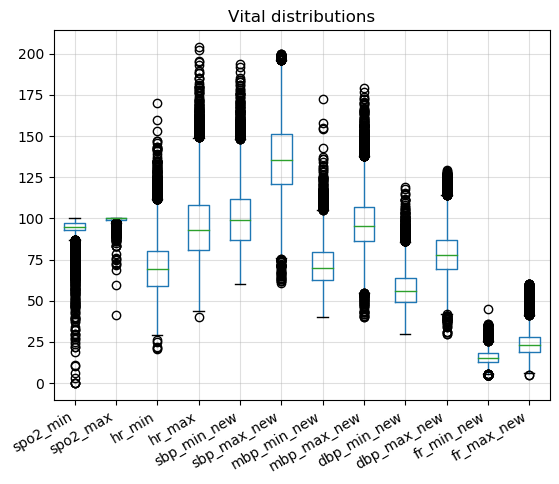

In [65]:
ax = vitals.drop(columns=['a_patientid']).boxplot()
xticks = ax.get_xticklabels()
_ = ax.set_xticklabels(xticks, rotation=30, ha='right')
_ = ax.set_title('Vital distributions')
_ = ax.grid(alpha=0.4)
plt.show()

In [66]:
np.round((vitals.isna().sum() / vitals.shape[0]) * 100, 2)

a_patientid     0.00
spo2_min        0.88
spo2_max        0.88
hr_min          0.90
hr_max          0.90
sbp_min_new     1.07
sbp_max_new     1.07
mbp_min_new     1.05
mbp_max_new     1.05
dbp_min_new     0.92
dbp_max_new     0.92
fr_min_new     16.57
fr_max_new     16.57
dtype: float64

In [67]:
features = albumine
features = features.merge(potassium, how='outer', on='a_patientid')
features = features.merge(haematocrit, how='outer', on='a_patientid')
features = features.merge(ph, how='outer', on='a_patientid')
features = features.merge(bun, how='outer', on='a_patientid')
features = features.merge(scr, how='outer', on='a_patientid')
features = features.merge(bicarbonate, how='outer', on='a_patientid')
features = features.merge(vitals, how='outer', on='a_patientid')
features

,a_patientid,albumine_min,albumine_max,potassium_min,potassium_max,haematocrit_min,haematocrit_max,ph_min,ph_max,bun_min,...,hr_min,hr_max,sbp_min_new,sbp_max_new,mbp_min_new,mbp_max_new,dbp_min_new,dbp_max_new,fr_min_new,fr_max_new
0,1000091,2.43,2.43,2.99,2.99,28.5,28.5,NaN,NaN,15.708,...,80.95,102.00,81.80,132.80,56.40,100.40,47.40,91.20,20.0,28.00
1,1000109,2.68,2.68,2.50,3.20,29.0,33.0,7.46,7.49,21.777,...,57.00,77.00,92.75,108.00,64.50,82.00,55.00,75.00,16.0,21.00
2,1002069,1.86,2.16,3.53,3.94,32.5,39.6,NaN,NaN,29.631,...,111.30,136.70,92.00,137.00,67.00,97.35,55.00,81.00,15.0,18.00
3,1002635,3.32,3.32,4.77,4.77,41.7,41.7,NaN,NaN,12.495,...,60.00,71.55,70.35,143.85,48.75,116.35,39.45,95.15,14.0,16.65
4,1002875,2.15,2.15,4.33,4.33,24.7,30.6,NaN,NaN,14.994,...,63.00,87.00,87.50,143.75,47.25,74.75,34.50,53.75,19.0,20.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21051,6330228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,86.00,92.00,NaN,NaN,NaN,NaN,NaN,NaN,17.0,24.00
21052,6671536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.70,84.60,112.00,112.00,78.00,78.00,64.15,66.85,9.7,20.00
21053,2591581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,22.00
21054,5477660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4,22.00


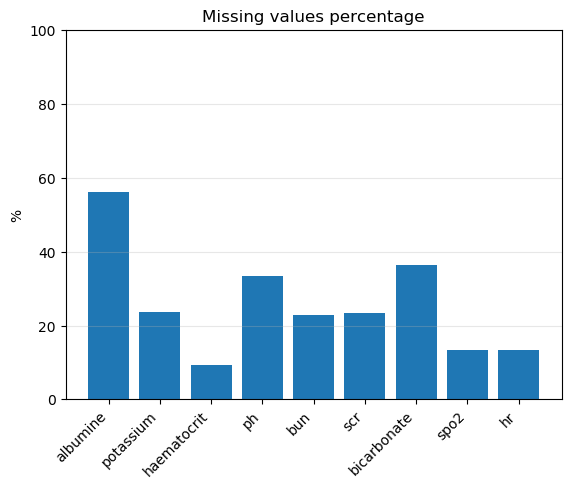

In [68]:
f, ax = plt.subplots()

cols = [col for col in features.columns.tolist() if col.endswith('max')]

missing = (features.loc[:, cols].isna().sum() / features.shape[0]) * 100
_ = ax.bar(x=range(missing.shape[0]), height=missing)
_ = ax.set_xticks(range(missing.shape[0]))
_ = ax.set_xticklabels([c.split('_')[0] for c in cols], rotation=45, ha='right')
_ = ax.grid(alpha=0.3, axis='y')
_ = ax.set_ylim((0,100))
_ = ax.set_ylabel('%')
_ = ax.set_title('Missing values percentage')
plt.show()

## CRRT

In [69]:
flux_idx = [
    1000001380,1000005666, # Flux
    2000001380,2000005666,
    3000001380,3000005666,
    4000001380,4000005666,
    5000001380,5000005666,
    6000001380,6000005666
]

flux = []
flux_tot = []
for tbl_name in tqdm(tables.str.extract('(.*monitored_numeric.*)').dropna()[0].values):
    ith_monitored = wr.s3.read_parquet(f's3://icusics-db/{tbl_name}')
    
    flux_ith = ith_monitored[ith_monitored.a_variableid.isin(flux_idx)]
    flux_tot.append(flux_ith)
    flux_ith_grp = flux_ith.groupby(['a_patientid','a_variableid']).time.min()
    flux.append(flux_ith_grp)

flux = pd.concat(flux)
flux_tot = pd.concat(flux_tot)
flux.head()

a_patientid  a_variableid
1001000      1000001380      1723
1002069      1000001380       345
1004363      1000001380      1004
1004645      1000001380       910
1008444      1000001380       448
Name: time, dtype: Int64

In [70]:
asd = flux.reset_index()
asd.time = asd.time.astype(float)
asd.a_variableid = asd.a_variableid.apply(lambda x: str(x)[2:])
asd = asd[asd.a_variableid.str.endswith('1380')]
#asd = asd[asd.time>=time_window]
outcome = asd.loc[:, ['a_patientid','time']]
outcome = outcome.rename(columns={'time':'crrt_time'})
outcome

,a_patientid,crrt_time
0,1001000,1723.0
1,1002069,345.0
2,1004363,1004.0
3,1004645,910.0
4,1008444,448.0
...,...,...
1654,6947160,1458.0
1655,6953205,1583.0
1656,6969036,15700.0
1657,6988953,23.0


## Comorbidities

 - Diabetes
 - Chronic Kidney Disease
 - Hyper tension
 - Heart failure

In [71]:
icusics_db_patients = wr.s3.read_parquet(path="s3://icusics-db/patients/patients.parquet")

icd_codes=[]
for h in icusics_db_patients.hospital_coded.unique():
    diagnoses = wr.s3.read_parquet(path="s3://icusics-db/diagnoses/diagnoses_h%s.parquet"%h)
    icd_codes.append(diagnoses)

icd_codes= pd.concat(icd_codes, ignore_index=True)

In [72]:
def get_comorbidity(icd_codes, comorbidity_codes, name, ids_to_exclude=None):
    comorbidity = icd_codes[icd_codes["referencecode"].str.startswith(comorbidity_codes)]
    if ids_to_exclude is not None:
        comorbidity = comorbidity[~comorbidity.referencecode.isin(ids_to_exclude)]
    hf = comorbidity.groupby("a_patientid").referencecode.count().reset_index().rename(columns={"referencecode": name})
    hf[name] = 1
    return hf

## Diabetes

In [74]:
diabetes_codes = ('E08', 'E09', 'E10', 'E11', 'E13', 'E23', '249', '250')
diab = get_comorbidity(icd_codes, diabetes_codes, 'diabetes')
diab

,a_patientid,diabetes
0,1001773,1
1,1002304,1
2,1002515,1
3,1002635,1
4,1003351,1
...,...,...
2320,6960538,1
2321,6980223,1
2322,6980759,1
2323,6982644,1


## Heart Failure

In [75]:
heartFail_codes = (
    'I50', 'I51', 'I11', 'I25.8', 'I27.8', 'I13.2', 'I43', 'I46',
    '428', 
)
hf = get_comorbidity(icd_codes, heartFail_codes, 'heart_failure')
hf

,a_patientid,heart_failure
0,1000999,1
1,1002304,1
2,1005104,1
3,1006270,1
4,1006302,1
...,...,...
1242,6947145,1
1243,6953205,1
1244,6954430,1
1245,6961989,1


## Hypertension

In [76]:
hyp_codes = (
    "I10", "401", "402", "I15","I13", "I11",
    'I12', 'I14', 'I16'
)
hyp = get_comorbidity(icd_codes, hyp_codes, 'hypertension')
hyp

,a_patientid,hypertension
0,1001773,1
1,1002304,1
2,1003351,1
3,1003886,1
4,1004336,1
...,...,...
4364,6980759,1
4365,6986777,1
4366,6996899,1
4367,6998846,1


## Chronic Kidney Disease

In [77]:
name ='chronic_kidney_disease'
ckd_codes = (
    'N18', '585', 'D63', #'E13', 'I13', 
    'I13.0', 'I13.1', 'I13.2', 'I13.11', 
    'I13.10', 'O10.32', 'O10.33', 'O10.3', 
    'O10.311', 'O10.312', 'O10.313', 'O10.319', 
    'E08.22', 'E10.22', 'E11.22', 'E11.21', 'N18.9', 
    'N18.1', 'N18.2', 'N18.3', 'N18.31', 
    'N18.32', 'N18.4', 'N18.5', 
    'N17', 'N19', 'N26', 'N28', 'N25'
)
ids_to_exclude = ["585.6","585.6/2"]
ckd = get_comorbidity(icd_codes, ckd_codes, 'chronic_kidney_disease', ids_to_exclude)
ckd

,a_patientid,chronic_kidney_disease
0,1000091,1
1,1001773,1
2,1002304,1
3,1003351,1
4,1004336,1
...,...,...
2718,6977755,1
2719,6982644,1
2720,6985215,1
2721,6991794,1


## RRT

In [78]:
name = 'RRT'
rrt_codes = ('N18.6', 'Z99.2')
rrt = get_comorbidity(icd_codes, rrt_codes, 'rrt')
rrt

,a_patientid,rrt
0,1592559,1
1,1601194,1
2,1771355,1
3,1773413,1
4,1807359,1
5,3070128,1
6,3246549,1
7,3421760,1
8,3802161,1
9,4122886,1


In [79]:
comorbidity = diab.merge(hf, how="outer")
comorbidity = comorbidity.merge(hyp, how="outer")
comorbidity = comorbidity.merge(ckd, how="outer")
comorbidity = comorbidity.merge(rrt, how="outer")

#comorbidity = comorbidity.fillna(0)
comorbidity

,a_patientid,diabetes,heart_failure,hypertension,chronic_kidney_disease,rrt
0,1001773,1.0,NaN,1.0,1.0,NaN
1,1002304,1.0,1.0,1.0,1.0,NaN
2,1002515,1.0,NaN,NaN,NaN,NaN
3,1002635,1.0,NaN,NaN,NaN,NaN
4,1003351,1.0,NaN,1.0,1.0,NaN
...,...,...,...,...,...,...
7193,6976110,NaN,NaN,NaN,1.0,NaN
7194,6977755,NaN,NaN,NaN,1.0,NaN
7195,6985215,NaN,NaN,NaN,1.0,NaN
7196,6991794,NaN,NaN,NaN,1.0,NaN


In [80]:
dataset = features.merge(comorbidity, how='left', on='a_patientid')
dataset = dataset.merge(outcome, how='left', on='a_patientid')

aki_24h = pd.read_csv('./data/max_aki_24h.csv')
dataset = dataset.merge(aki_24h, how='left', on='a_patientid')

dataset['crrt_24_134_h'] = np.where((dataset.crrt_time> 24*60) & (dataset.crrt_time<= 134*60), 1, 0)
dataset

,a_patientid,albumine_min,albumine_max,potassium_min,potassium_max,haematocrit_min,haematocrit_max,ph_min,ph_max,bun_min,...,fr_min_new,fr_max_new,diabetes,heart_failure,hypertension,chronic_kidney_disease,rrt,crrt_time,aki_stage,crrt_24_134_h
0,1000091,2.43,2.43,2.99,2.99,28.5,28.5,NaN,NaN,15.708,...,20.0,28.00,NaN,NaN,NaN,1.0,NaN,NaN,0.0,0
1,1000109,2.68,2.68,2.50,3.20,29.0,33.0,7.46,7.49,21.777,...,16.0,21.00,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
2,1002069,1.86,2.16,3.53,3.94,32.5,39.6,NaN,NaN,29.631,...,15.0,18.00,NaN,NaN,NaN,NaN,NaN,345.0,3.0,0
3,1002635,3.32,3.32,4.77,4.77,41.7,41.7,NaN,NaN,12.495,...,14.0,16.65,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0
4,1002875,2.15,2.15,4.33,4.33,24.7,30.6,NaN,NaN,14.994,...,19.0,20.00,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21051,6330228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.0,24.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
21052,6671536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.7,20.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
21053,2591581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.0,22.00,NaN,1.0,NaN,1.0,NaN,NaN,0.0,0
21054,5477660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.4,22.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


In [81]:
patients = wr.s3.read_parquet(path="s3://icusics-db/patients/patients.parquet")

cols = ['a_patientid','patientsex','age','height','weight','bmi']
dataset = patients.loc[:, cols].merge(dataset, how='right', on='a_patientid')

dataset.patientsex = dataset.patientsex.replace({'M':0, 'F':1})
dataset

,a_patientid,patientsex,age,height,weight,bmi,albumine_min,albumine_max,potassium_min,potassium_max,...,fr_min_new,fr_max_new,diabetes,heart_failure,hypertension,chronic_kidney_disease,rrt,crrt_time,aki_stage,crrt_24_134_h
0,1000091,0,70,160,50,20,2.43,2.43,2.99,2.99,...,20.0,28.00,NaN,NaN,NaN,1.0,NaN,NaN,0.0,0
1,1000109,0,50,160,80,31,2.68,2.68,2.50,3.20,...,16.0,21.00,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
2,1002069,1,70,160,60,23,1.86,2.16,3.53,3.94,...,15.0,18.00,NaN,NaN,NaN,NaN,NaN,345.0,3.0,0
3,1002635,0,80,160,60,23,3.32,3.32,4.77,4.77,...,14.0,16.65,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0
4,1002875,1,50,160,90,35,2.15,2.15,4.33,4.33,...,19.0,20.00,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21051,6330228,1,70,170,80,28,NaN,NaN,NaN,NaN,...,17.0,24.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
21052,6671536,1,40,160,70,27,NaN,NaN,NaN,NaN,...,9.7,20.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
21053,2591581,0,70,180,100,31,NaN,NaN,NaN,NaN,...,22.0,22.00,NaN,1.0,NaN,1.0,NaN,NaN,0.0,0
21054,5477660,1,70,160,60,23,NaN,NaN,NaN,NaN,...,9.4,22.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


In [82]:
dataset.to_csv('./data/raw_dataset.csv', index=False)

EXCLUSION CRITERIA 

CRRT in the first 24 h 

In [83]:
dataset['exclude_per_crrt']= np.where(dataset.crrt_time <= 24*60, 1,0)
dataset['exclude_per_crrt'].sum()

594

aki < 1

In [84]:
dataset['exclude_per_stage']= np.where(dataset.aki_stage < 1, 1,0)
dataset['exclude_per_stage'].sum()

5328

In [85]:
final_ds = dataset[dataset.exclude_per_stage == 0]
final_ds = final_ds[final_ds.exclude_per_crrt == 0]
final_ds = final_ds[final_ds.rrt.fillna(0) == 0]
final_ds = final_ds.drop(columns=['exclude_per_stage','exclude_per_crrt','rrt'])
print(final_ds.shape[0])

final_ds.to_csv('./data/catalunia_dataset_cleaned_v2.csv', index=False)
final_ds.head()

15149


,a_patientid,patientsex,age,height,weight,bmi,albumine_min,albumine_max,potassium_min,potassium_max,...,dbp_max_new,fr_min_new,fr_max_new,diabetes,heart_failure,hypertension,chronic_kidney_disease,crrt_time,aki_stage,crrt_24_134_h
1,1000109,0,50,160,80,31,2.68,2.68,2.50,3.20,...,75.00,16.0,21.00,NaN,NaN,NaN,NaN,NaN,2.0,0
3,1002635,0,80,160,60,23,3.32,3.32,4.77,4.77,...,95.15,14.0,16.65,1.0,NaN,NaN,NaN,NaN,1.0,0
4,1002875,1,50,160,90,35,2.15,2.15,4.33,4.33,...,53.75,19.0,20.00,NaN,NaN,NaN,NaN,NaN,2.0,0
5,1003452,1,80,160,60,23,2.39,2.39,3.20,4.40,...,94.10,16.0,25.00,NaN,NaN,NaN,NaN,NaN,2.0,0
6,1003886,0,70,170,110,38,2.53,2.53,3.92,3.92,...,71.80,15.0,26.00,1.0,NaN,1.0,NaN,NaN,2.0,0
